In [62]:
using Optim, LsqFit
using Plots, StatsPlots, LaTeXStrings
using StatsBase
using DelimitedFiles
using Statistics
using Turing
using DataFrames
using BenchmarkTools
using LazyArrays

In [33]:
pyplot(grid=:off)

Plots.PyPlotBackend()

In [3]:
ENV["COLUMNS"]=120
figdir = "figures/";

# Viral load data fitting

## Confidence intervals and goodness of fit

## Data set

10 mice with 13 data points each

In [4]:
RAWDATA = readdlm("../../data/To2020/Figure_2_Viral_Load.csv", ',', Any, '\n', header=true)[1]
COLS = readdlm("../../data/To2020/Figure_2_Viral_Load.csv", ',', Any, '\n', header=true)[2]
DataFrame(RAWDATA, :auto)

30×24 DataFrame
 Row │ x1   x2       x3       x4       x5       x6       x7       x8       x9       x10      x11      x12      x13     ⋯
     │ Any  Any      Any      Any      Any      Any      Any      Any      Any      Any      Any      Any      Any     ⋯
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 0                                                                                                               ⋯
   2 │ 1    5.21924
   3 │ 2                                                                   8.42034                    3.76403
   4 │ 3    4.77062                                                        6.05675
   5 │ 4                      8.63656                                      6.21165  4.85564  6.04999                   ⋯
   6 │ 5             7.38193                    6.6963                     7.11621  6.68878  1
   7 │ 6    1        7.35384                                      7.04338  1
   8 │ 7    5.29376                                                        4.7673
   9 │ 8    1                 7.85297  8.4431                     6.96152  5.14451                                     ⋯
  10 │ 9    1        6.34922           4.51444  5.57185                    5.02366           4.86356           6.77699
  11 │ 10   4.32197                    4.2957            5.17365  3.93571  3.40161
  ⋮  │  ⋮      ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮    ⋱
  21 │ 20   3.28592  1                 8.93792                             2.94448           4.3476
  22 │ 21   1                          1                                   1                 4.6175                    ⋯
  23 │ 22   1                          1                                   2.98588           4.47851
  24 │ 23   1        1                 4.79574                             1                 3.90827
  25 │ 24   1        1                 4.7673
  26 │ 25   1                          1                                                                               ⋯
  27 │ 26   1        1                 1
  28 │ 27   1                          1
  29 │ 28            1                 1
  30 │ 29                              1                                                                               ⋯
                                                                                           11 columns and 9 rows omitted

In [5]:
data = copy(RAWDATA)
data[data .== ""] .= missing
tdata = Float64.(data[:, 1]);
data[[7,9, 10, 12, 13, 14, 16, 17, 19], 2] .= missing
data[[22, 23], 5] .= missing
data[[7, 22], 9] .= missing
data[[6, ], 11] .= missing
data[[25, 26], 16] .= missing
data[[17, ], 17] .= missing
data[[7, ], 19] .= missing
data[[12, ], 20] .= missing
data[[9, 10], 21] .= missing
data[[1, 30], 2:end] .= 1.;

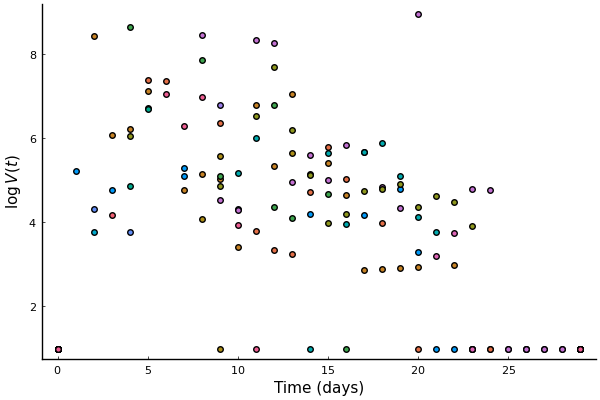

In [6]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[:, i], seriestype=:scatter) for i in 2:size(data, 2)]
plt

## Standard virus load function

The virus load function with three main phases given by

$$V(t; p)=v_1(t; a_1, a_2, V_{\max})v_2(t; a_2, \alpha)v_3(t; b_1, b_2, V_{\min}),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t; a_1, a_2, V_{\max}) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t; a_2, \alpha) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t; b_1, b_2, V_{\min}) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function, and $p=(a_1, a_2, b_1, b_2, \alpha, V_{\min}, V_{\max})^t$ is the vector of parameters. There are non-nengativity $a_1, a_2, b_1, b_2, \alpha, V_{\min}, V_{\max} >0$, and ordering $0<a_1<a_2<b_1<b_2$ conditions.

In [7]:
# H(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
H(x) = 0.5*(tanh(1e3*x) + 1.)
function v₁(t, a₁, a₂, logVmax)
    1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/abs(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/abs(a₂ - a₁)))/2
end
function v₂(t, a₂, α) 
    1. - H(t - a₂) + H(t - a₂)*exp(-α*(t - a₂))
end
function v₃(t, b₁, b₂, logVmin)
    1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/abs(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/abs(b₂ - b₁)))/2
end
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    θ = minimum(vvdata)
    logVmin = -6.0
    logV = log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
    max(logV, θ)
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"];

In [8]:
function assert_params(a₁, a₂, b₁, b₂, α, logVmax)
    all([a₁ < a₂, a₂ < b₁, b₁ < b₂, a₁ > 0, a₂ > 0, b₁ > 0, b₂ > 0, α > 0, logVmax > 0])
end

assert_params (generic function with 1 method)

In [39]:
k = 2
ttdata = repeat(tdata, inner=1)
tend = ttdata[end]
vvdata = reshape(data[:, k], 1, :)[:]
idx = .!ismissing.(vvdata)
ttdata = ttdata[idx]
vvdata = vvdata[idx]
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

## Optimization

As see

Estimate $\hat p$

In [10]:
function fitVLF()
    bestfit = nothing 
    for i = 1:10
        par0 = vcat(sort(ttdata[end]*rand(4)), [0.80, maximum(vvdata)])
        lb   = vcat(0.0, (par0[1:3] + par0[2:4])/2, [1e-8, par0[6] - 4])
        ub   = vcat((par0[1:3] + par0[2:4])/2, [tend, 10.0, par0[6] + 4])
        fit1 = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^6))
        if assert_params(fit1.minimizer...)
            if bestfit == nothing
                bestfit = fit1
            else
                if fit1.minimum < bestfit.minimum 
                    bestfit = fit1
                end
            end
        end
    end
    return bestfit
end

fitVLF (generic function with 1 method)

In [11]:
fit1 = fitVLF()

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
35 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 49951

     Obj. value:     61.3175012002

       parameter      search width
         0.00000           0.00000 
        23.68747           0.00000 
        26.34882           0.00000 
        29.00000           0.00000 
        10.00000           0.00000 
         3.98308           0.00000 

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
22 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 49651

     Obj. value:      5.6362654522

       parameter      search width
         0.00000           0.00000 

 * Status: failure

 * Candidate solution
    Final objective value:     3.753618e+00

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    49051
    f(x) calls:    49051
    ∇f(x) calls:   0


RSS = 3.7536178240750546
a₁ = 1.482291555660952e-14
a₂ = 5.288746130173892
b₁ = 17.75408117547018
b₂ = 20.931649509809567
α = 0.22820935119477534
logVmax = 5.539812302626157


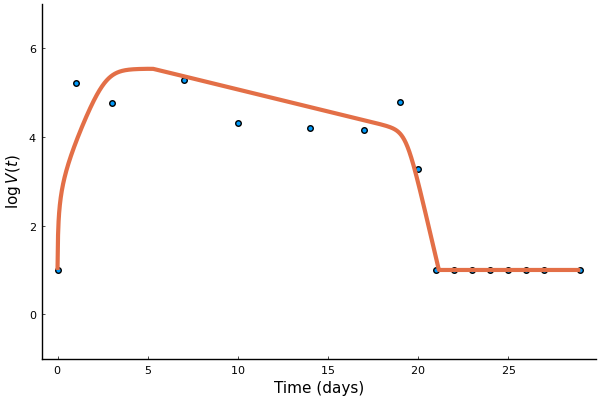

In [12]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.minimizer...)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
println("RSS = ", fit1.minimum)
[println(p, " = ", v) for (p, v) in zip(par_names, fit1.minimizer)];
pt

## Confidence intervals

Construct confidence intervals using MCMC and three approaches:

 a) Sample from the posterior distribution given individual data using a probabilistic model for each parameter and time dependent variance.
 
 b) Sample from the posterior distribution given individual data using a probabilistic model for each parameter and time-constant variance.

 c) Sample from the predictive posterior distribution given individual data using a probabilistic model for each parameter and time-constant variance.
 
 d) Sample from the posterior distribution given aggregated data using a probabilistic model for each parameter and time-constant variance.

 ?) Sample from the posterios distributrion and model with the mixed-effect model (NL-MELSM). (TODO)

In [13]:
# k = 1
# ttdata = tdata
# vvdata = data[k, :]
# tend = ttdata[end]
# cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)
# fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))

In [54]:
# sampler = PG(10); nsamples = 1000; nchains = 4;
sampler = HMC(0.01, 5); nsamples = 12000; nchains = 4;
# sampler = NUTS(); nsamples = 2000; nchains = 4;

###  a) Sample from the posterior distribution given individual data using a probabilistic model for each parameter and time dependent variance.

 - Variability per time
 
 - Prior distributions assume equal variability
 
 - Estimation per individual using population best estimate for the prior

$$
s \sim Exp(1) \\
a_1 \sim N(\hat a_1, s, 0, \infty) \\
a_2 \sim N(\hat a_2, s, a_1, \infty) \\
b_1 \sim N(\hat b_1, s, a_2, \infty) \\
b_2 \sim N(\hat b_2, s, b_1, \infty) \\
\alpha \sim N(\hat \alpha, s, 0, \infty) \\
\log V_{max} \sim N(\log \hat V_{max}, s, 0, \infty) \\
\sigma \sim N(\vec{0}, sI) \\
V(t_i) = N(\log V (t_i; \theta), \sigma_i )
$$

where 

$$
\theta = (a_1, a_2, b_1, b_2, \alpha, \log V_{max})
$$

However, this is not correct since it models separate errors for each observation.

In [15]:
@model function VLFmodel(t, v, p₀)
    # For each time point t[i], v[i] is a vector of observations
    # For now t and v have the same size, i.e. one obseravtion por time point
    tmax = maximum(t)
    # Prior distributions
    s ~ Exponential(1.0/std(v))
    a₁ ~ truncated(Normal(p₀[1], s), 0, p₀[3])
    a₂ ~ truncated(Normal(p₀[2], s), a₁, p₀[4])
    b₁ ~ truncated(Normal(p₀[3], s), a₂, tmax)
    b₂ ~ truncated(Normal(p₀[4], s), b₁, tmax)
    α ~ truncated(Normal(p₀[5], s), 0, Inf)
    logVmax ~ truncated(Normal(p₀[6], s), 0, Inf)
    σ ~ filldist(truncated(Normal(), 0, Inf), size(t, 1))
    # Model
    threshold = 0
    for i ∈ eachindex(v)
        v[i] ~ truncated(Normal(LogVirusLoad(t[i], a₁, a₂, b₁, b₂, α, logVmax), σ[i]), threshold, Inf)
    end
    return v
end

VLFmodel (generic function with 1 method)

In [16]:
chains_prior = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit1.minimizer), 
                         Prior(), nsamples), chainscat, 1:nchains)
chains = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit1.minimizer), 
                   sampler, nsamples), chainscat, 1:nchains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:33
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:26
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:18


Chains MCMC chain (1000×26×4 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 120.61 seconds
Compute duration  = 119.89 seconds
parameters        = α, σ[3], b₁, σ[4], σ[14], a₂, σ[5], σ[12], σ[16], σ[1], σ[15], a₁, σ[17], σ[6], logVmax, s, σ[10], σ[13], σ[11], σ[2], σ[7], σ[8], b₂, σ[9]
internals         = lp, logevidence

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   ess_per_sec 
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64       Float64 

           s    0.2819    0.2717     0.0043    0.0406   11.0297    1.9478        0.0920
          a₁    0.1906    0.2408     0.0038    0.0368   10.0064    2.2868        0.0835
          a₂    5.3236    0.4553     0.0072    0.0701    9.8176    2.1180        0.0819
          b₁   17.4842    0.7974     0.0126    0.1238    8.7452    3.3224        0.0729
          b₂   21.0514    0.2935     0.0046    0.0445   1

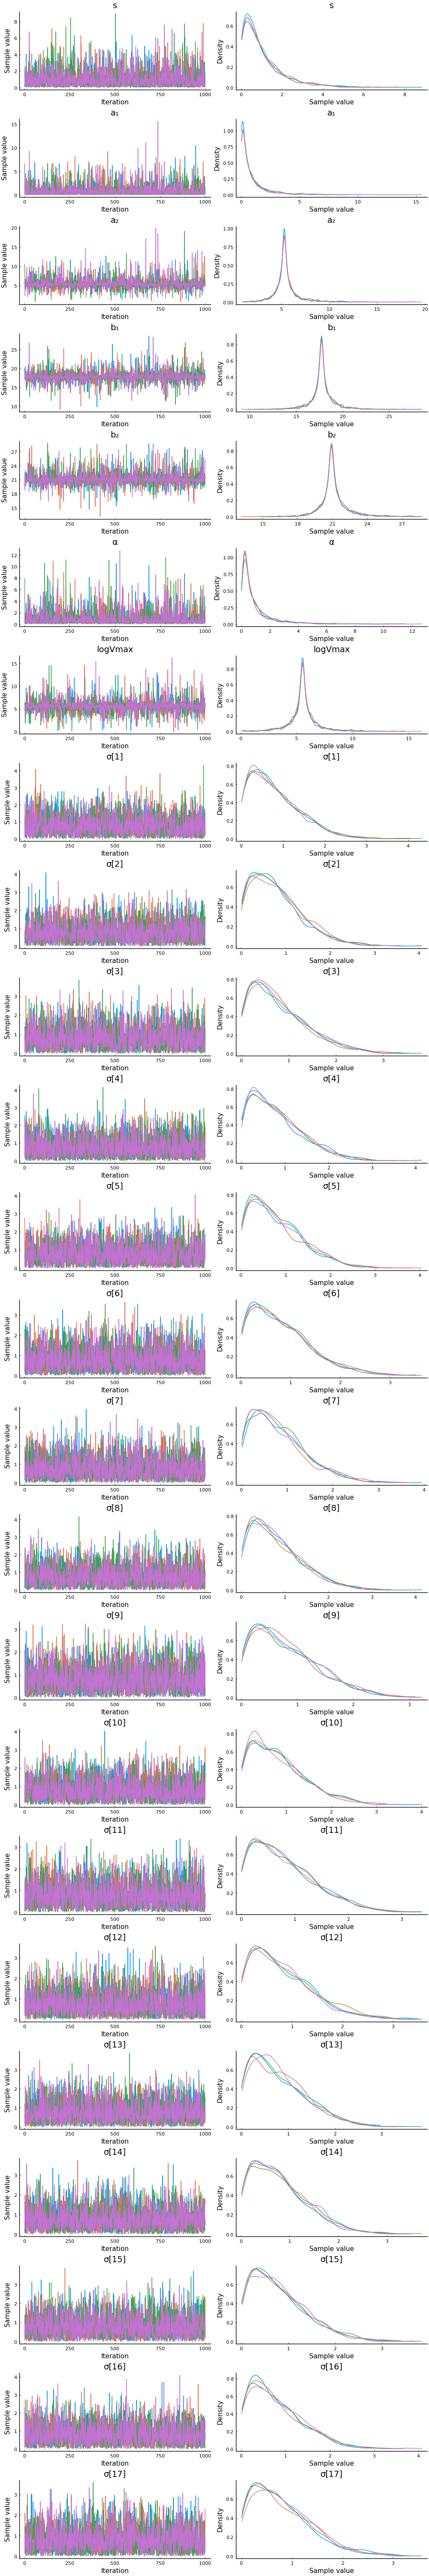

In [17]:
plot(chains_prior)

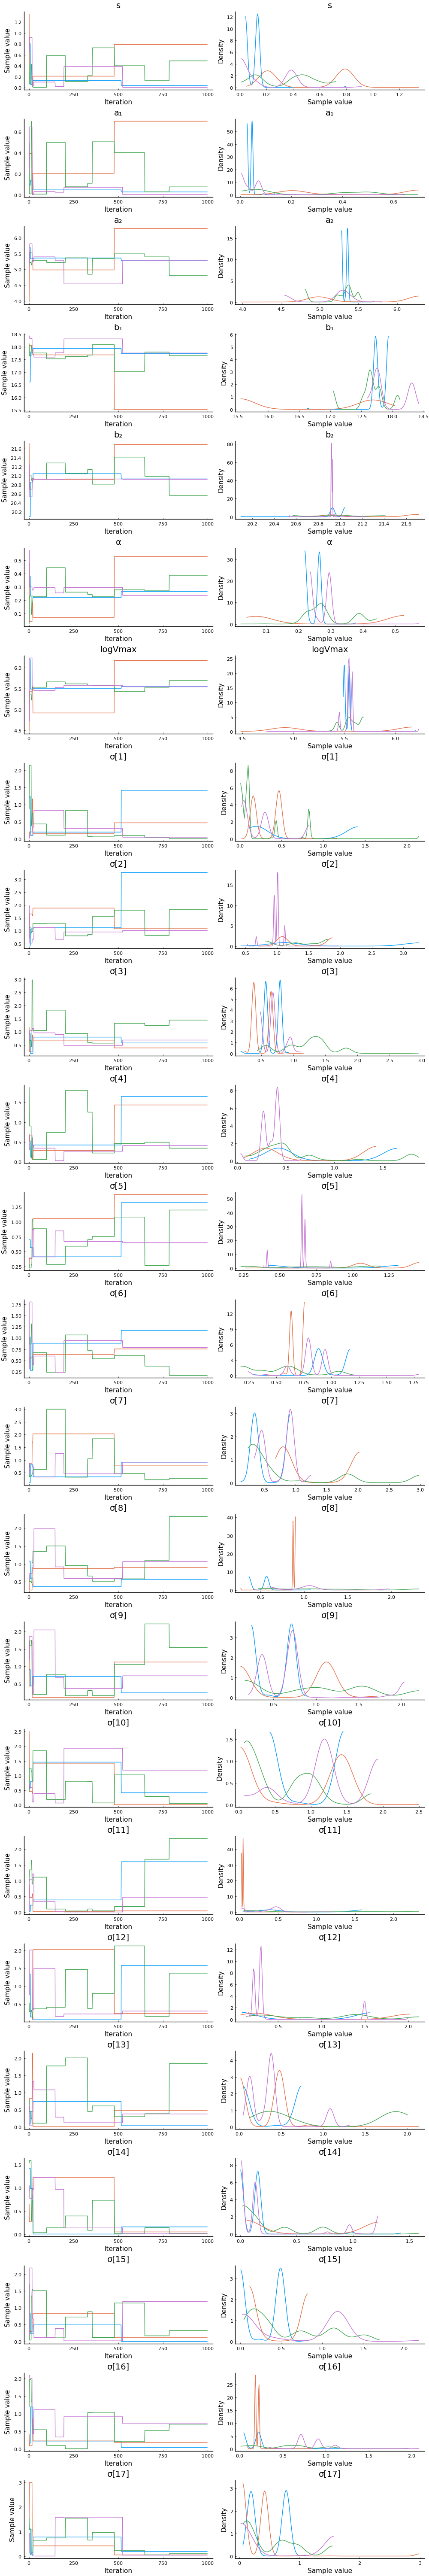

In [18]:
plot(chains)

Good convergence

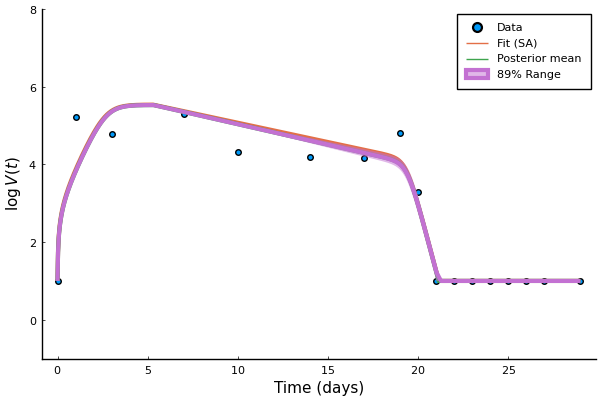

In [19]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
plot(ttdata, vvdata, seriestype=:scatter, label="Data")
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.minimizer...)
plot!(tt, vv, lw=3, label="Fit (SA)")
p = mean.(eachcol(df))
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3, label="Posterior mean")
arr = [filter(!isnan, LogVirusLoad.(t, eachcol(df)...)) for t in tt]
m = [mean(v) for v in arr]
quantiles = [quantile(v, [0.055, 0.945]) for v in arr]
lower = [m - q[1] for (q, m) in zip(quantiles, m)]
upper = [q[2] - m for (q, m) in zip(quantiles, m)]
plot!(tt, m, lw=3, ribbon = [lower, upper], label=("89% Range"))
plot!(grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

Errors seem a little high.

### b) Sample from the posterior distribution given individual data using a probabilistic model for each parameter and time-constant variance.

To compute predictive posterior values we need to use common variance

In [47]:
@model function VLFmodel(t, v, p₀)
    tmax = maximum(t)
    # Prior distributions
    s ~ Exponential(1.0)
    a₁ ~ truncated(Normal(1, s), 0, tmax)
    a₂ ~ truncated(Normal(2, s), 0, tmax)
    b₁ ~ truncated(Normal(10, s), 0, tmax)
    b₂ ~ truncated(Normal(12, s), 0, tmax)
    α ~ truncated(Normal(0.5, s), 0, Inf)
    logVmax ~ truncated(Normal(maximum(v), s), 0, Inf)
    σ ~ Exponential(1/std(v))
    # Model
    threshold = minimum(v)
    for i ∈ eachindex(v)
        v[i] ~ truncated(Normal(LogVirusLoad(t[i], a₁, a₂, b₁, b₂, α, logVmax), σ), threshold, Inf)
    end
    return v
end

VLFmodel (generic function with 1 method)

In [76]:
mle_estimate = optimize(VLFmodel(ttdata, vvdata, fit1.minimizer), MLE(), SimulatedAnnealing())

┌ Warning: Optimization did not converge! You may need to correct your model or adjust the Optim parameters.
└ @ Turing /home/shigoto/.julia/packages/Turing/YGtAo/src/modes/ModeEstimation.jl:407


ModeResult with maximized lp of -16.22
8-element Named Vector{Float64}
A        │ 
─────────┼──────────
:s       │ 0.0303891
:a₁      │ 0.0100417
:a₂      │   4.37016
:b₁      │   18.6506
:b₂      │    26.491
:α       │  0.528518
:logVmax │   5.89198
:σ       │    1.0764

In [77]:
mle_estimate.values.array

8-element Vector{Float64}:
  0.030389139491522946
  0.010041724803128408
  4.370161710337194
 18.650621934375906
 26.491009554255783
  0.5285176383523817
  5.891976360655758
  1.0764045117559917

In [78]:
chains = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit1.minimizer), 
                   sampler, nsamples), chainscat, 1:nchains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (12000×17×4 Array{Float64, 3}):

Iterations        = 1:1:12000
Number of chains  = 4
Samples per chain = 12000
Wall duration     = 13.05 seconds
Compute duration  = 12.71 seconds
parameters        = α, σ, s, b₁, a₁, a₂, b₂, logVmax
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   ess_per_sec 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64       Float64 

           s    2.5256    2.4972     0.0114    0.1113   107.7432    1.5901        8.4790
          a₁    3.5838    5.6277     0.0257    0.2557   102.3226    1.4909        8.0525
          a₂    2.4773    3.3967     0.0155    0.1538   113.4809    1.1044        8.9306
          b₁   12.9654    4.5778     0.0209    0.2061   102.0361    2.9228        8.0299
          b₂   13.5693    4.0699     0.0186    0

Sample for the posterior and predict, however, this does not include uncertainty from the data.

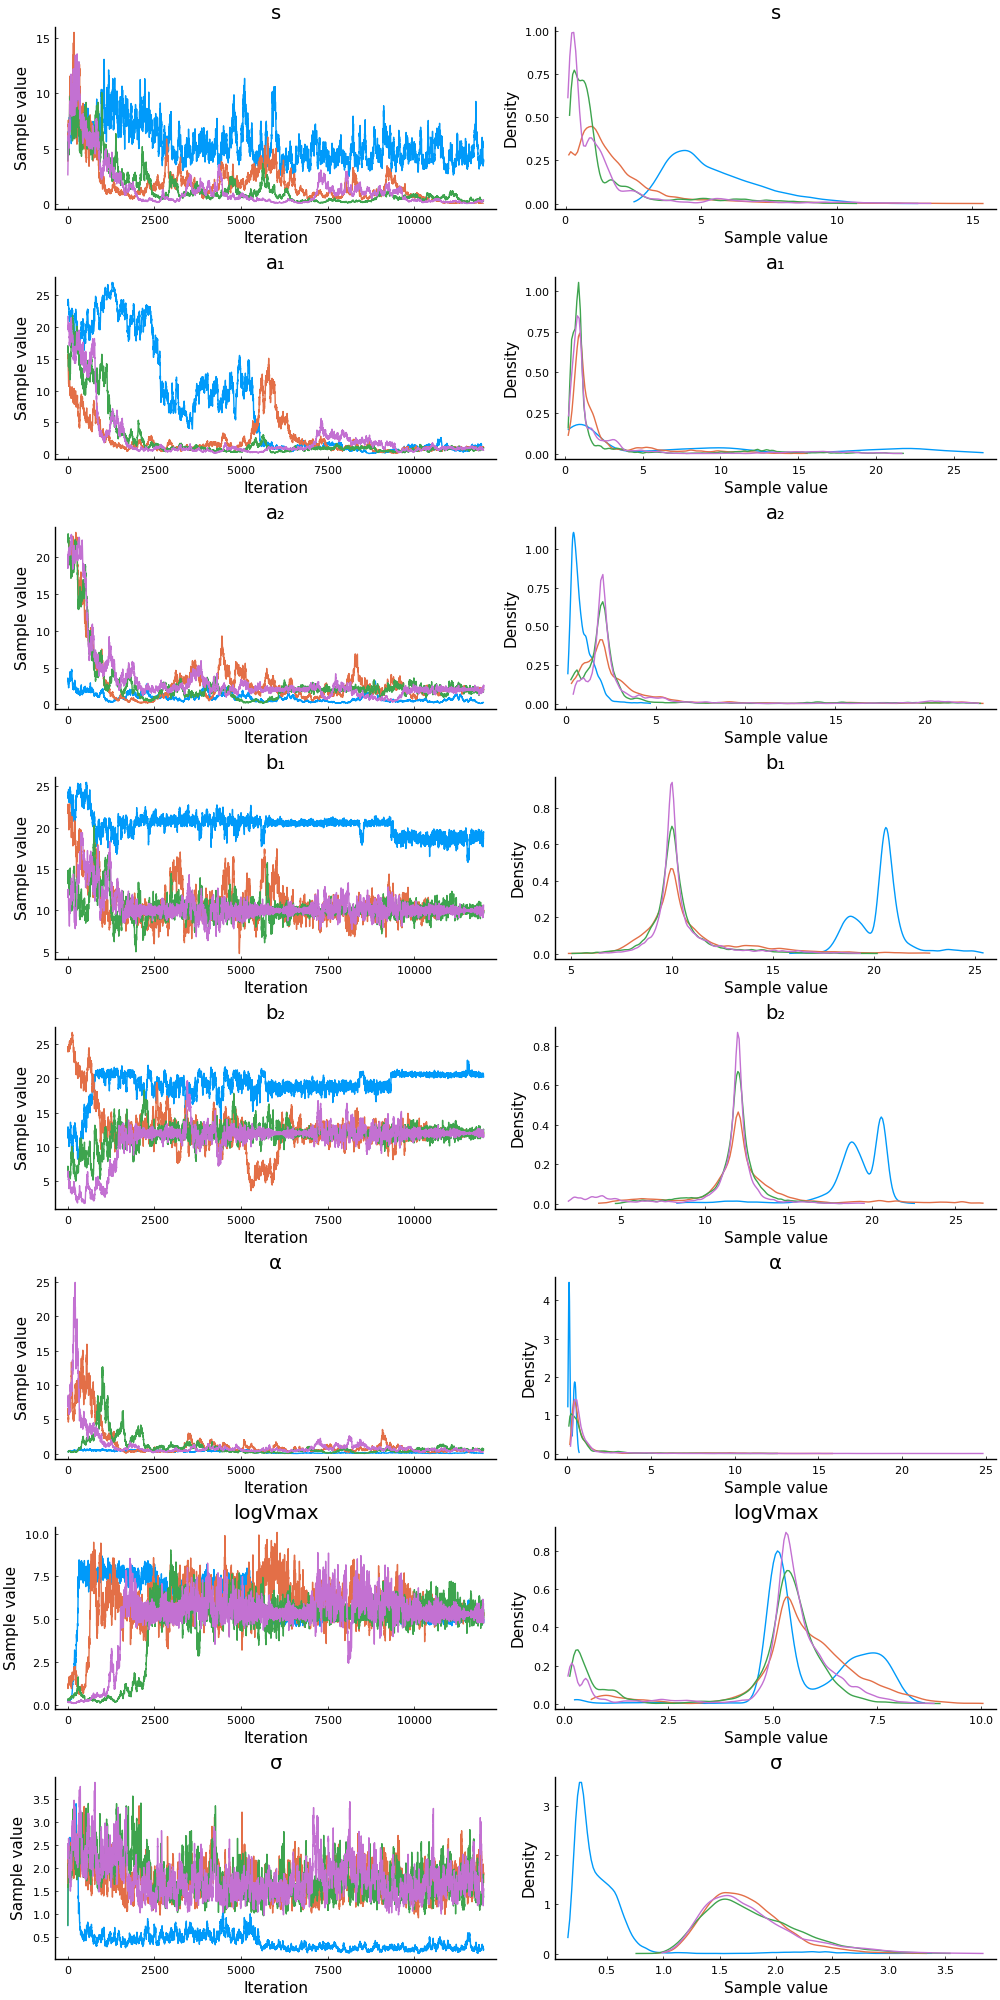

In [79]:
plot(chains)

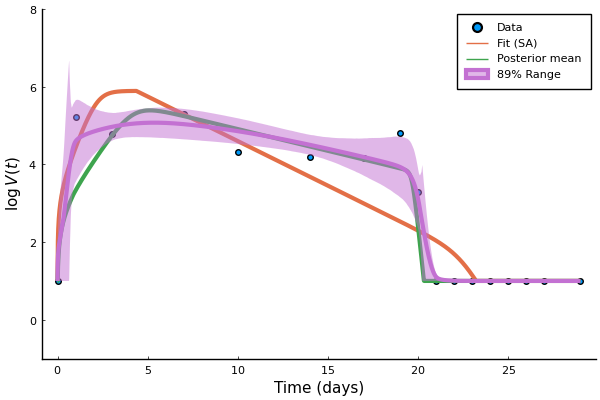

In [80]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
plot(ttdata, vvdata, seriestype=:scatter, label="Data")
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, mle_estimate.values.array[2:(end-1)]...)
plot!(tt, vv, lw=3, label="Fit (SA)")
p = mean.(eachcol(df))
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3, label="Posterior mean")
arr = [filter(!isnan, LogVirusLoad.(t, eachcol(df)...)) for t in tt]
m = [mean(v) for v in arr]
quantiles = [quantile(v, [0.055, 0.945]) for v in arr]
lower = [m - q[1] for (q, m) in zip(quantiles, m)]
upper = [q[2] - m for (q, m) in zip(quantiles, m)]
plot!(tt, m, lw=3, ribbon = [lower, upper], label=("89% Range"))
plot!(grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

## All mice

In [23]:
data

30×24 Matrix{Any}:
  0  1.0       1.0       1.0       1.0       1.0       1.0       …  1.0       1.0       1.0       1.0       1.0
  1  5.21924    missing   missing   missing   missing   missing      missing   missing   missing   missing   missing
  2   missing   missing   missing   missing   missing   missing      missing   missing   missing   missing   missing
  3  4.77062    missing   missing   missing   missing   missing      missing   missing   missing   missing   missing
  4   missing   missing  8.63656    missing   missing   missing      missing   missing   missing   missing   missing
  5   missing  7.38193    missing   missing  6.6963     missing  …   missing   missing   missing   missing   missing
  6   missing  7.35384    missing   missing   missing   missing      missing   missing   missing   missing   missing
  7  5.29376    missing   missing   missing   missing   missing      missing   missing   missing   missing  6.28565
  8   missing   missing  7.85297   8.4431     missi

In [24]:
k = size(data, 2)
ttdata = repeat(tdata, inner=k-1)
vvdata = reshape(data[:, 2:k]', 1, :)[:]
tend = ttdata[end]
idx = .!ismissing.(vvdata)
ttdata = ttdata[idx]
vvdata = vvdata[idx]
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

In [25]:
fit1 = fitVLF()

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
7 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 53401

     Obj. value:    281.6916357041

       parameter      search width
         0.00000           0.00000 
         5.03536           0.00000 
        15.23868           0.00000 
        25.55270           0.00000 
         0.30137           0.00000 
         6.05703           0.00000 

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
13 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 54001

     Obj. value:    287.5901759107

       parameter      search width
         0.00000           0.00000 


 * Status: failure

 * Candidate solution
    Final objective value:     2.816916e+02

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   46  (vs limit Inf)
    Iterations:    53401
    f(x) calls:    53401
    ∇f(x) calls:   0


In [26]:
@model function VLFmodel(t, v, p₀)
    tmax = maximum(t)
    # Prior distributions
    s ~ Exponential(1.0)
    a₁ ~ truncated(Normal(p₀[1], s), 0, p₀[3])
    a₂ ~ truncated(Normal(p₀[2], s), a₁, p₀[4])
    b₁ ~ truncated(Normal(p₀[3], s), a₂, tmax)
    b₂ ~ truncated(Normal(p₀[4], s), b₁, tmax)
    α ~ truncated(Normal(p₀[5], s), 0, Inf)
    logVmax ~ truncated(Normal(p₀[6], s), 0, Inf)
    σ ~ truncated(Normal(), 0, Inf)
    # Model
    for i ∈ eachindex(v)
        v[i] ~ Normal(LogVirusLoad(t[i], a₁, a₂, b₁, b₂, α, logVmax), σ)
    end
    return v
end

chains = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit1.minimizer), 
                   sampler, nsamples), chainscat, 1:nchains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:44
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:44
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:58
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:45


Chains MCMC chain (1000×10×4 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 438.29 seconds
Compute duration  = 438.11 seconds
parameters        = α, σ, s, b₁, a₁, a₂, b₂, logVmax
internals         = lp, logevidence

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   ess_per_sec 
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64       Float64 

           s    0.2969    0.3371     0.0053    0.0499   20.2836    1.1844        0.0463
          a₁    0.2673    0.2382     0.0038    0.0352   17.3350    1.2845        0.0396
          a₂    4.9642    0.2297     0.0036    0.0337   24.5584    1.1187        0.0561
          b₁   15.3762    0.3417     0.0054    0.0494   26.0759    1.1940        0.0595
          b₂   25.3581    0.3415     0.0054    0.0507   14.8934    1.3934        0.0340
           α    0.3166    0.0811     0.0013    0.0110   27.7938    1.1094   

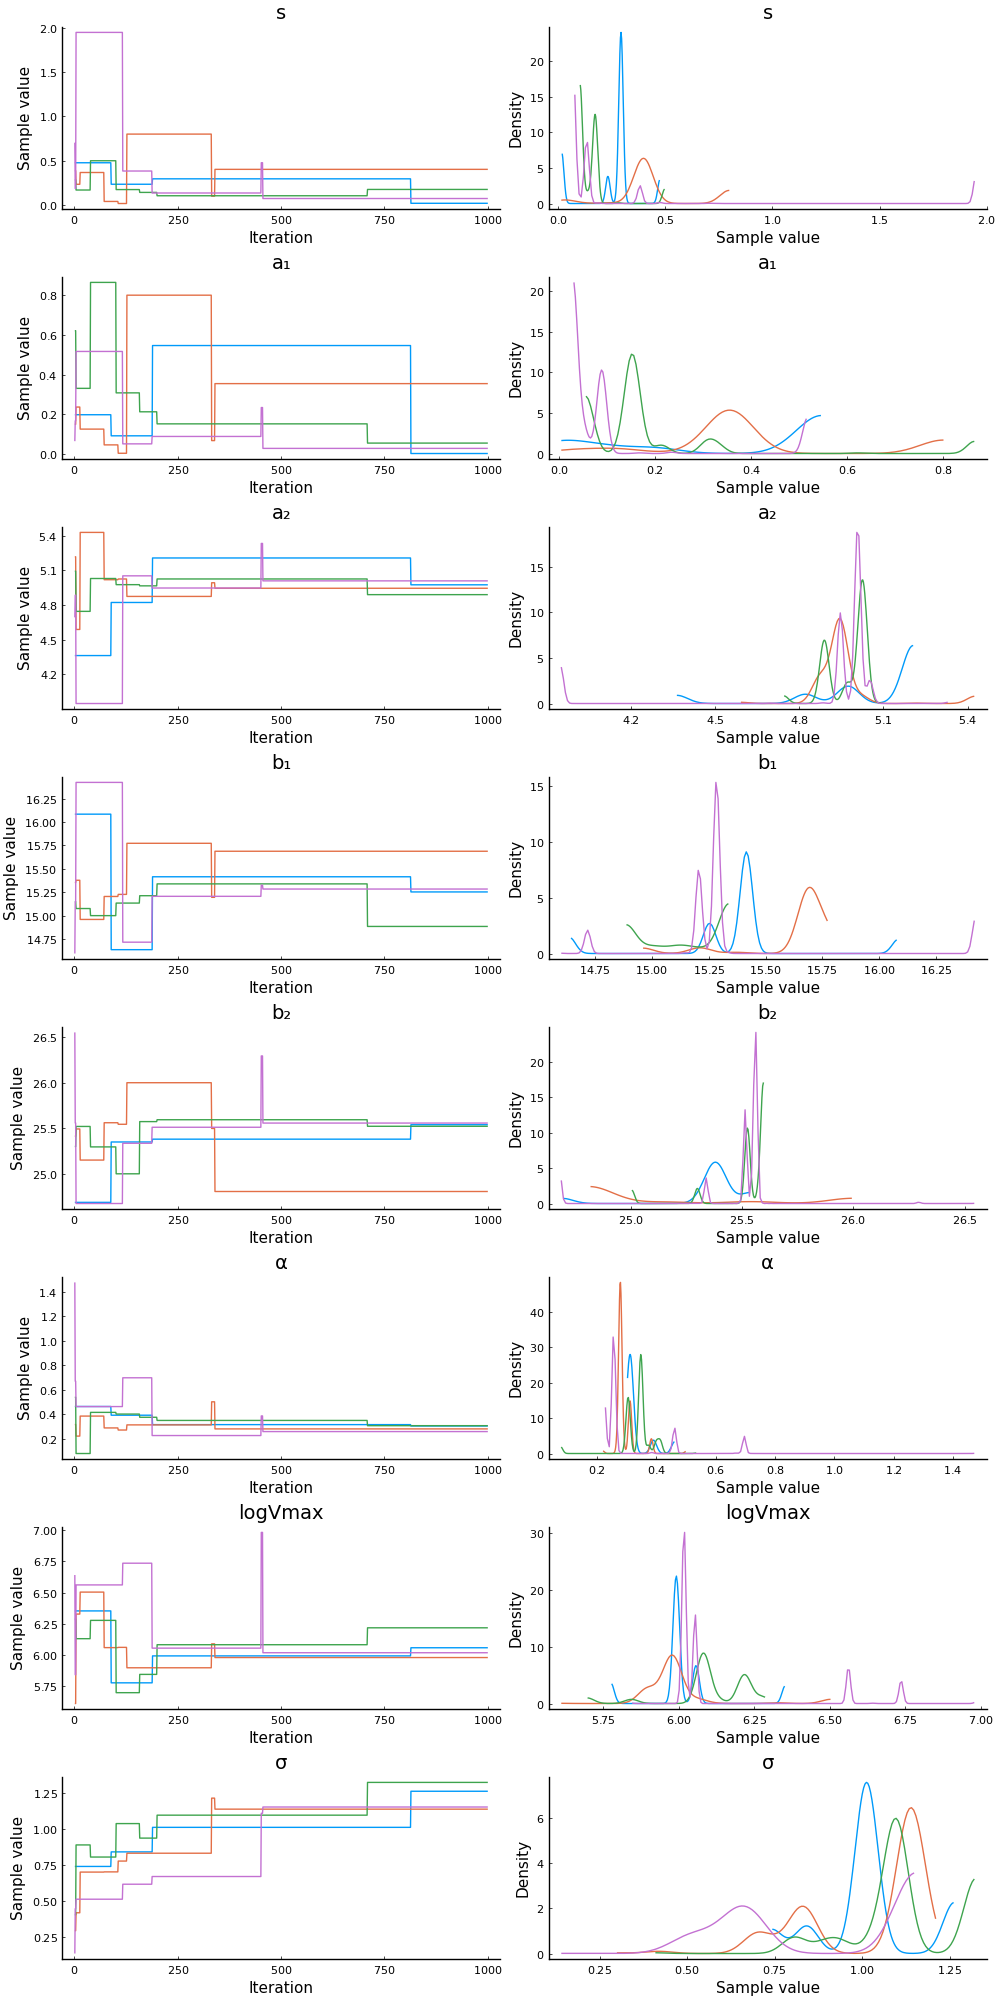

In [27]:
plot(chains)

In [28]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
# plot(ttdata, vvdata, seriestype=:scatter)
# tt = [range(0., tend, step=1e-2);]
m = mean.(eachcol(df))
l = quantile.(eachcol(df), 0.05)
u = quantile.(eachcol(df), 0.95)
[println(par_names[i], " = ", m[i], ", CI=[", l[i], ",", u[i], "]") for i in eachindex(m)];

a₁ = 0.3690275168184551, CI=[0.0021953091983983315,0.5472697986078582]
a₂ = 5.050241258175778, CI=[4.362924586025942,5.2062949539243215]
b₁ = 15.365879425913596, CI=[14.635949162319084,16.084513651036527]
b₂ = 25.348622162200584, CI=[24.691460514964295,25.540930625094408]
α = 0.33263958520765347, CI=[0.30286148648854877,0.46206496788182877]
logVmax = 6.014478886914644, CI=[5.776011359665842,6.353022141797928]


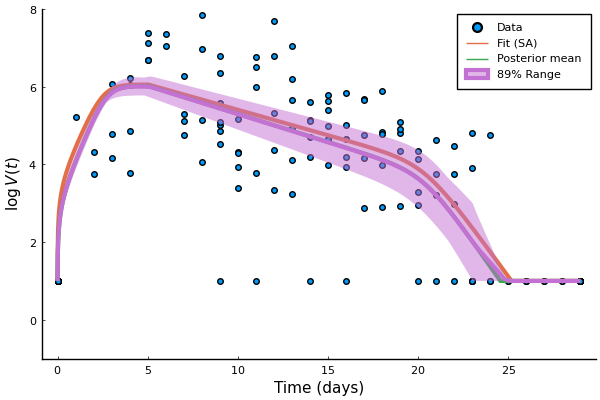

In [29]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
plot(ttdata, vvdata, seriestype=:scatter, label="Data")
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.minimizer...)
plot!(tt, vv, lw=3, label="Fit (SA)")
p = mean.(eachcol(df))
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3, label="Posterior mean")
arr = [filter(!isnan, LogVirusLoad.(t, eachcol(df)...)) for t in tt]
m = [mean(v) for v in arr]
quantiles = [quantile(v, [0.055, 0.945]) for v in arr]
lower = [q[1] - m for (q, m) in zip(quantiles, m)]
upper = [q[2] - m for (q, m) in zip(quantiles, m)]
plot!(tt, m, lw=3, ribbon = [lower, upper], label=("89% Range"))
plot!(grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

## Compute a set of best parameters

$$
\hat \Theta = \{\theta \in \mathbb{R}^k \,|\, \text{RSS}(\theta) = \sum_i \|f(t_i, \theta) - y_i\|^2 < \epsilon \}.
$$

In [29]:
k = 2
ttdata = repeat(tdata, inner=1)
tend = ttdata[end]
vvdata = reshape(data[:, k], 1, :)[:]
idx = .!ismissing.(vvdata)
ttdata = ttdata[idx]
vvdata = vvdata[idx]
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

In [30]:
# @model function prior(tmax, lVmax)
#     a₁ ~ Uniform(0, 2.5)
#     a₂ ~ Uniform(a₁, tmax)
#     b₁ ~ Uniform(a₂, tmax)
#     b₂ ~ Uniform(b₁, tmax)
#     α ~ truncated(Normal(0, 2), 0, Inf)
#     logVmax ~ truncated(Normal(lVmax, 1), 0, Inf)
# end
# prior_sample = sample(prior(tdata[end], mean(maximum.(eachrow(data)))), 
#                          Prior(), 100)
# density(prior_sample[:a₁])
# density!(prior_sample[:a₂])
# density!(prior_sample[:b₁])
# density!(prior_sample[:bddd₂])
# plot!(xlim=(0, tdata[end]))

In [31]:
function my_prior_rand(p)
    tmax = tdata[end]
    s = .1
    a₁ = rand(truncated(Normal(p[1], s), 0, tmax))
    a₂ = rand(truncated(Normal(p[2], s), a₁, tmax))
    b₁ = rand(truncated(Normal(p[3], s), a₂, tmax))
    b₂ = rand(truncated(Normal(p[4], s), b₁, tmax))
    α = rand(truncated(Normal(p[5], s), 0, Inf))
    logVmax = rand(truncated(Normal(p[6], s), 0, Inf))
    return [a₁, a₂, b₁, b₂, α, logVmax]
end

my_prior_rand (generic function with 1 method)

In [32]:
fit1 = fitVLF()

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
13 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 57301

     Obj. value:      5.5745850713

       parameter      search width
         0.00000           0.00000 
         9.08667           0.00000 
        19.38057           0.00000 
        20.39276           0.00000 
         0.35345           0.00000 
         5.64649           0.00000 

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
25 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 49201

     Obj. value:      5.7975949362

       parameter      search width
         0.00000           0.00000 

 * Status: failure

 * Candidate solution
    Final objective value:     1.736019e+00

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    50401
    f(x) calls:    50401
    ∇f(x) calls:   0


In [33]:
par_array = []
RSS_array = []
maxiter = 10^4
# println("RSS: ", fit1.minimum)
tol = 1e0
for k = 1:maxiter
#     println("\nIter: ", k)
    par = my_prior_rand(fit1.minimizer)
    rss = cost(par)
#     if (rss - fit.minimum)/fit.minimum < tol
#         println("passed")
        push!(par_array, par)
        push!(RSS_array, cost(par))
#     end
end
# length(par_array)

In [34]:
tol = 1e-1
RSS_best = minimum(RSS_array)
idx = (RSS_array .- RSS_best)/RSS_best .< tol
par_best = par_array[idx]
print(sum(idx), " best estimates found within ", RSS_best, " + ", tol)
# par_best = par_array
RSS_array[idx];

3 best estimates found within 1.179900657364935 + 0.1

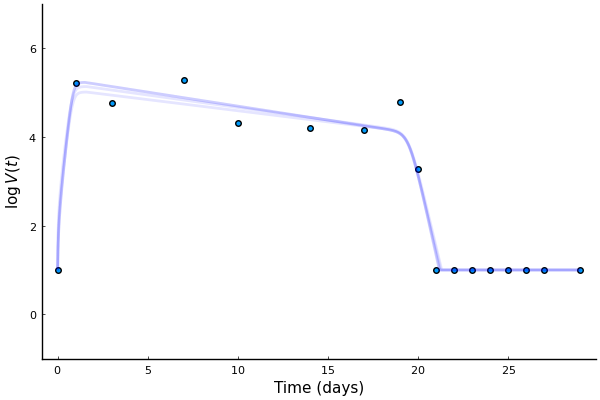

In [35]:
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
for par ∈ par_best
    vv = LogVirusLoad.(tt, par...)
#     println(par)
    plot!(tt, vv, line=(2, :blue, 0.1))
end
plot!(tt, vv, line=(2, :blue, 0.1))
plot!(legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))